## Lab 8 Part II: Plotting Contoured Upper-Air Data
<br /><br />

In this part of the tutorial, we are going to plot GFS model-derived isohypses, isotherms, and wind barbs to aid in analyzing fronts at different levels.
<br />
### Module Documentation

1. Xarray Dataset: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html
2. Matplotlib Pyplot: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
3. Caropy crs: https://scitools.org.uk/cartopy/docs/latest/reference/crs.html
4. Cartopy Feature: https://scitools.org.uk/cartopy/docs/latest/matplotlib/feature_interface.html
5. Matplotlib Colors: https://matplotlib.org/stable/gallery/color/named_colors.html
6. Matplotlib Contour: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html
7. Matplotlib Barbs: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.barbs.html
8. Scipy Gaussian Filter: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html
9. Xarray with MetPy: https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html



If you have any questions about the code below, feel free to reach out to me at mpvossen@uwm.edu. I am always willing to further explain the code. <br /> <br />

---

<br />
1. As usual, we start by importing the modules we need for our Python code.

In [1]:
#from the dates and time code(datetime), import the date and time reading capabilities (datetime)
from datetime import datetime

#import the module numpy and save it to np
import numpy as np

#import the cartopy (cartopy) module's coordinate reference system (.crs) and save it to the variable crs
import cartopy.crs as crs

#import the cartopy (cartopy) module's ability to plot geographic data (.feature) and save it to the variable cfeature 
import cartopy.feature as cfeature

#import the pyplot submodule from the matplotlib module
import matplotlib.pyplot as plt

#from the scipy module's ndimage submodule, import the function gaussian_filter
from scipy.ndimage import gaussian_filter

#import the module xarray and save it to xr
import xarray as xr

#from the metpy submodule units import the units function
from metpy.units import units

#import the calculation submodule form the metpy module and save it to the variable calc
import metpy.calc as calc

#import the pandas module and save it to the variable pd
import pandas as pd

<br /><br />
2. As with other labs, we will create a function to process our data.  In the function below, I create a function for you that opens GFS analysis data and converts the units of the temperature data to degrees Celsius and wind data to knots. 

In [2]:
"""
Below, I define a function to retrieve and process upper-air data.  This function opens the GFS analysis data
and converts the temperature units from Kelvin to Celsius and wind units from m/s to knots.


INPUT:
    time : DATETIME
        The time at which you would like upper-air data.
    
OUTPUT:

    model_data : XARRAY DATASET
        The xarray containing your processed GFS analysis data

"""

def process_upper_air_data(time):
    """
    Specify the location of the upper-air data on the JupyterHub.
    """
    lab_data_loc = "/data/AtmSci360/Lab_8/"
    
    """
    Open the GFS data using xarray.  Since the data are once again GRIB-formatted data, we can use xarray the same way we did in Lab 4.
    The data file name is still formatted %m%d%y_%H.grib2.  Only open the variables with a vertical coordinate of isobaricInhPa.
    """
    model_data = xr.open_dataset(f"{lab_data_loc}{time:%m%d%y_%H}_gfs.grib2", engine='cfgrib', filter_by_keys={'typeOfLevel': 'isobaricInhPa'})
    
    
    """
    Our temperature (t) is in Kelvin and our wind variables (u and v) are in m/s.  Here, we convert temperature to degrees Celsius
    and the wind variables to m/s, saving them back to the xarray as we do so.
    """
    model_data['t'] = model_data["t"].metpy.convert_units('degC')
    model_data['u'] = model_data["u"].metpy.convert_units('kt')
    model_data['v'] = model_data["v"].metpy.convert_units('kt')
    

    """
    Finally, have the function return the processed data.
    """
    return model_data


<br /><br />
3. Call the data processing function to get data for January 5th, 2022 at 0000 UTC.

In [3]:
time=datetime(2022,1,5,0)
model_data=process_upper_air_data(time)

Ignoring index file '/data/AtmSci360/Lab_8/010522_00_gfs.grib2.923a8.idx' incompatible with GRIB file
skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 660, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/dataset.py", line 593, in dict_merge
    "key=%r value=%r new_value=%r" % (key, master[key], value)
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850

<br /><br />
4. We are ready to create our plotting function.  Follow the comments in the code block below to create a plot with isohypses, isotherms, and wind barbs at a user-specified level.

In [4]:
"""
Below a function is defined to plot upper-air geopotential height (line contour), temperature (line contour), and wind (barbs).


INPUT:
    model_data : XARRAY DATASET
        The GFS analysis data
    level : INTEGER
        The level that the plot is valid for.
    data : DATETIME
        The date and time that the plot is valid for.

"""


def gfs_temp_upper_air_plot(model_data, level, date):
    
    """
    Since we are plotting multiple levels, we need to limit the data to the level we want to plot.
    When the data processing script was created it was designed to pull the data for all levels so we can
    create plots at multiple levels without having to download data each time.
    
    In the line below, like in data processing functions we have created in previous labs, parse the data
    so that only the level that the user specified in the GFS analysis data is retained.
    """
    model_data = model_data.sel(isobaricInhPa = level)
    
    
    """
    Setup a Lambert Conic Conformal Projection centered at 35°N and 95°W.  Have the cone of the Lambert Conic Conformal projection intersect the Earth at 27.5°N and 42.5°N.
    """
    proj = crs.LambertConformal(central_longitude=-95, central_latitude=35, standard_parallels=[27.5,42.5])
    
    
    """
    Create a figure with a size of 1150px x 800px and a resolution of 300 dots per inch,
    then set up an axes object (named ax) using the projection we previously defined for our map.
    """
    fig = plt.figure(figsize=(11.5,8),dpi=300)
    ax = plt.subplot(projection = proj)

    """
    Add an appropriate amount of geographic data.  Be sure you follow "good map" suggestions with the geographic data styling.
    """
    ax.add_feature(cfeature.LAND.with_scale('50m'), edgecolor = "black", facecolor='none',  linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor = "black",  facecolor='none', linewidth=0.75, zorder=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor = "grey", linestyle=":", facecolor='none', linewidth=0.5, zorder=1)

    

        
    """
    Limit the map to between 105°-75°W longitude and 32°-55°N latitude.
    """
    ax.set_extent((-105, -75, 32, 55))
    
    """   
    Set up a Gaussian filter for the geopotential heights ('gh'). Choose an appropriate smoothing value for these data.
    """
    smooth_heights = gaussian_filter(model_data["gh"].values,2)

    """
    Contour the smoothed geopotential heights.  Be sure to style your contours so they are easy to read and make sure they have labels.
    """
    cont_p = plt.contour(model_data["longitude"].values, model_data["latitude"].values, smooth_heights, np.arange(0,10000,30),linewidths = 0.5,colors='k', transform=crs.PlateCarree())
    ax.clabel(cont_p, cont_p.levels, fmt=lambda v: format(v, '.0f'),fontsize=6)
   
    """
    Set up a Gaussian filter for the temperature ('t'). Choose an appropriate smoothing value for these data.
    """
    smooth_temp = gaussian_filter(model_data["t"].values,2)
    
    """
    Contour the smoothed temperatures.  Be sure to style your contours so they are easy to read 
    (including having them be distinct from the geopotential height contours) and make sure they have labels.
    """
    cont_t=plt.contour(model_data["longitude"].values, model_data["latitude"].values,smooth_temp,np.arange(-35,32,2),colors='r',linewidths = 0.5, linestyles="solid",transform=crs.PlateCarree(), alpha=0.6, zorder=1)
    ax.clabel(cont_t, cont_t.levels,fmt=lambda v: format(v, '.0f'),inline=True,fontsize=6)
    

    
    
    
    
    """
    Now we are ready to add our wind barbs.  To start, create the x- and y-wind slices for the wind
    data, defined so that every 8 points in the x and y directions are skipped.
    """
    wind_slice_x = slice(None, None, 8)
    wind_slice_y = slice(None, None, 8)
    
    """
    Add styling information to the barb plotting argument below to make the wind barbs easier to read.
    """
    ax.barbs(model_data["longitude"][wind_slice_x].values, model_data["latitude"][wind_slice_y].values,
             model_data["u"][wind_slice_x, wind_slice_y].values,
             model_data["v"][wind_slice_x, wind_slice_y].values,
             color='black',transform=crs.PlateCarree(),linewidth=0.6,length=4.25)
    
    
    """
    Add an appropriate title to your plot.
    """ 
    plt.title(f"{level}hpa Oberservations, Geopotential Height (black| dm), Temperature (red| C)",size=6,weight="bold",loc="left")
    plt.title(f"Valid: {time:%m/%d/%Y %H%M} UTC", size=5, loc="right") 
              
    
    
    plt.show()


<br /><br />
5. Run your plotting function for 850 hPa, 700 hPa, and 500 hPa with the data we downloaded earlier with our data processing script.

/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/opt/tljh/user/lib/python3.7/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iterati

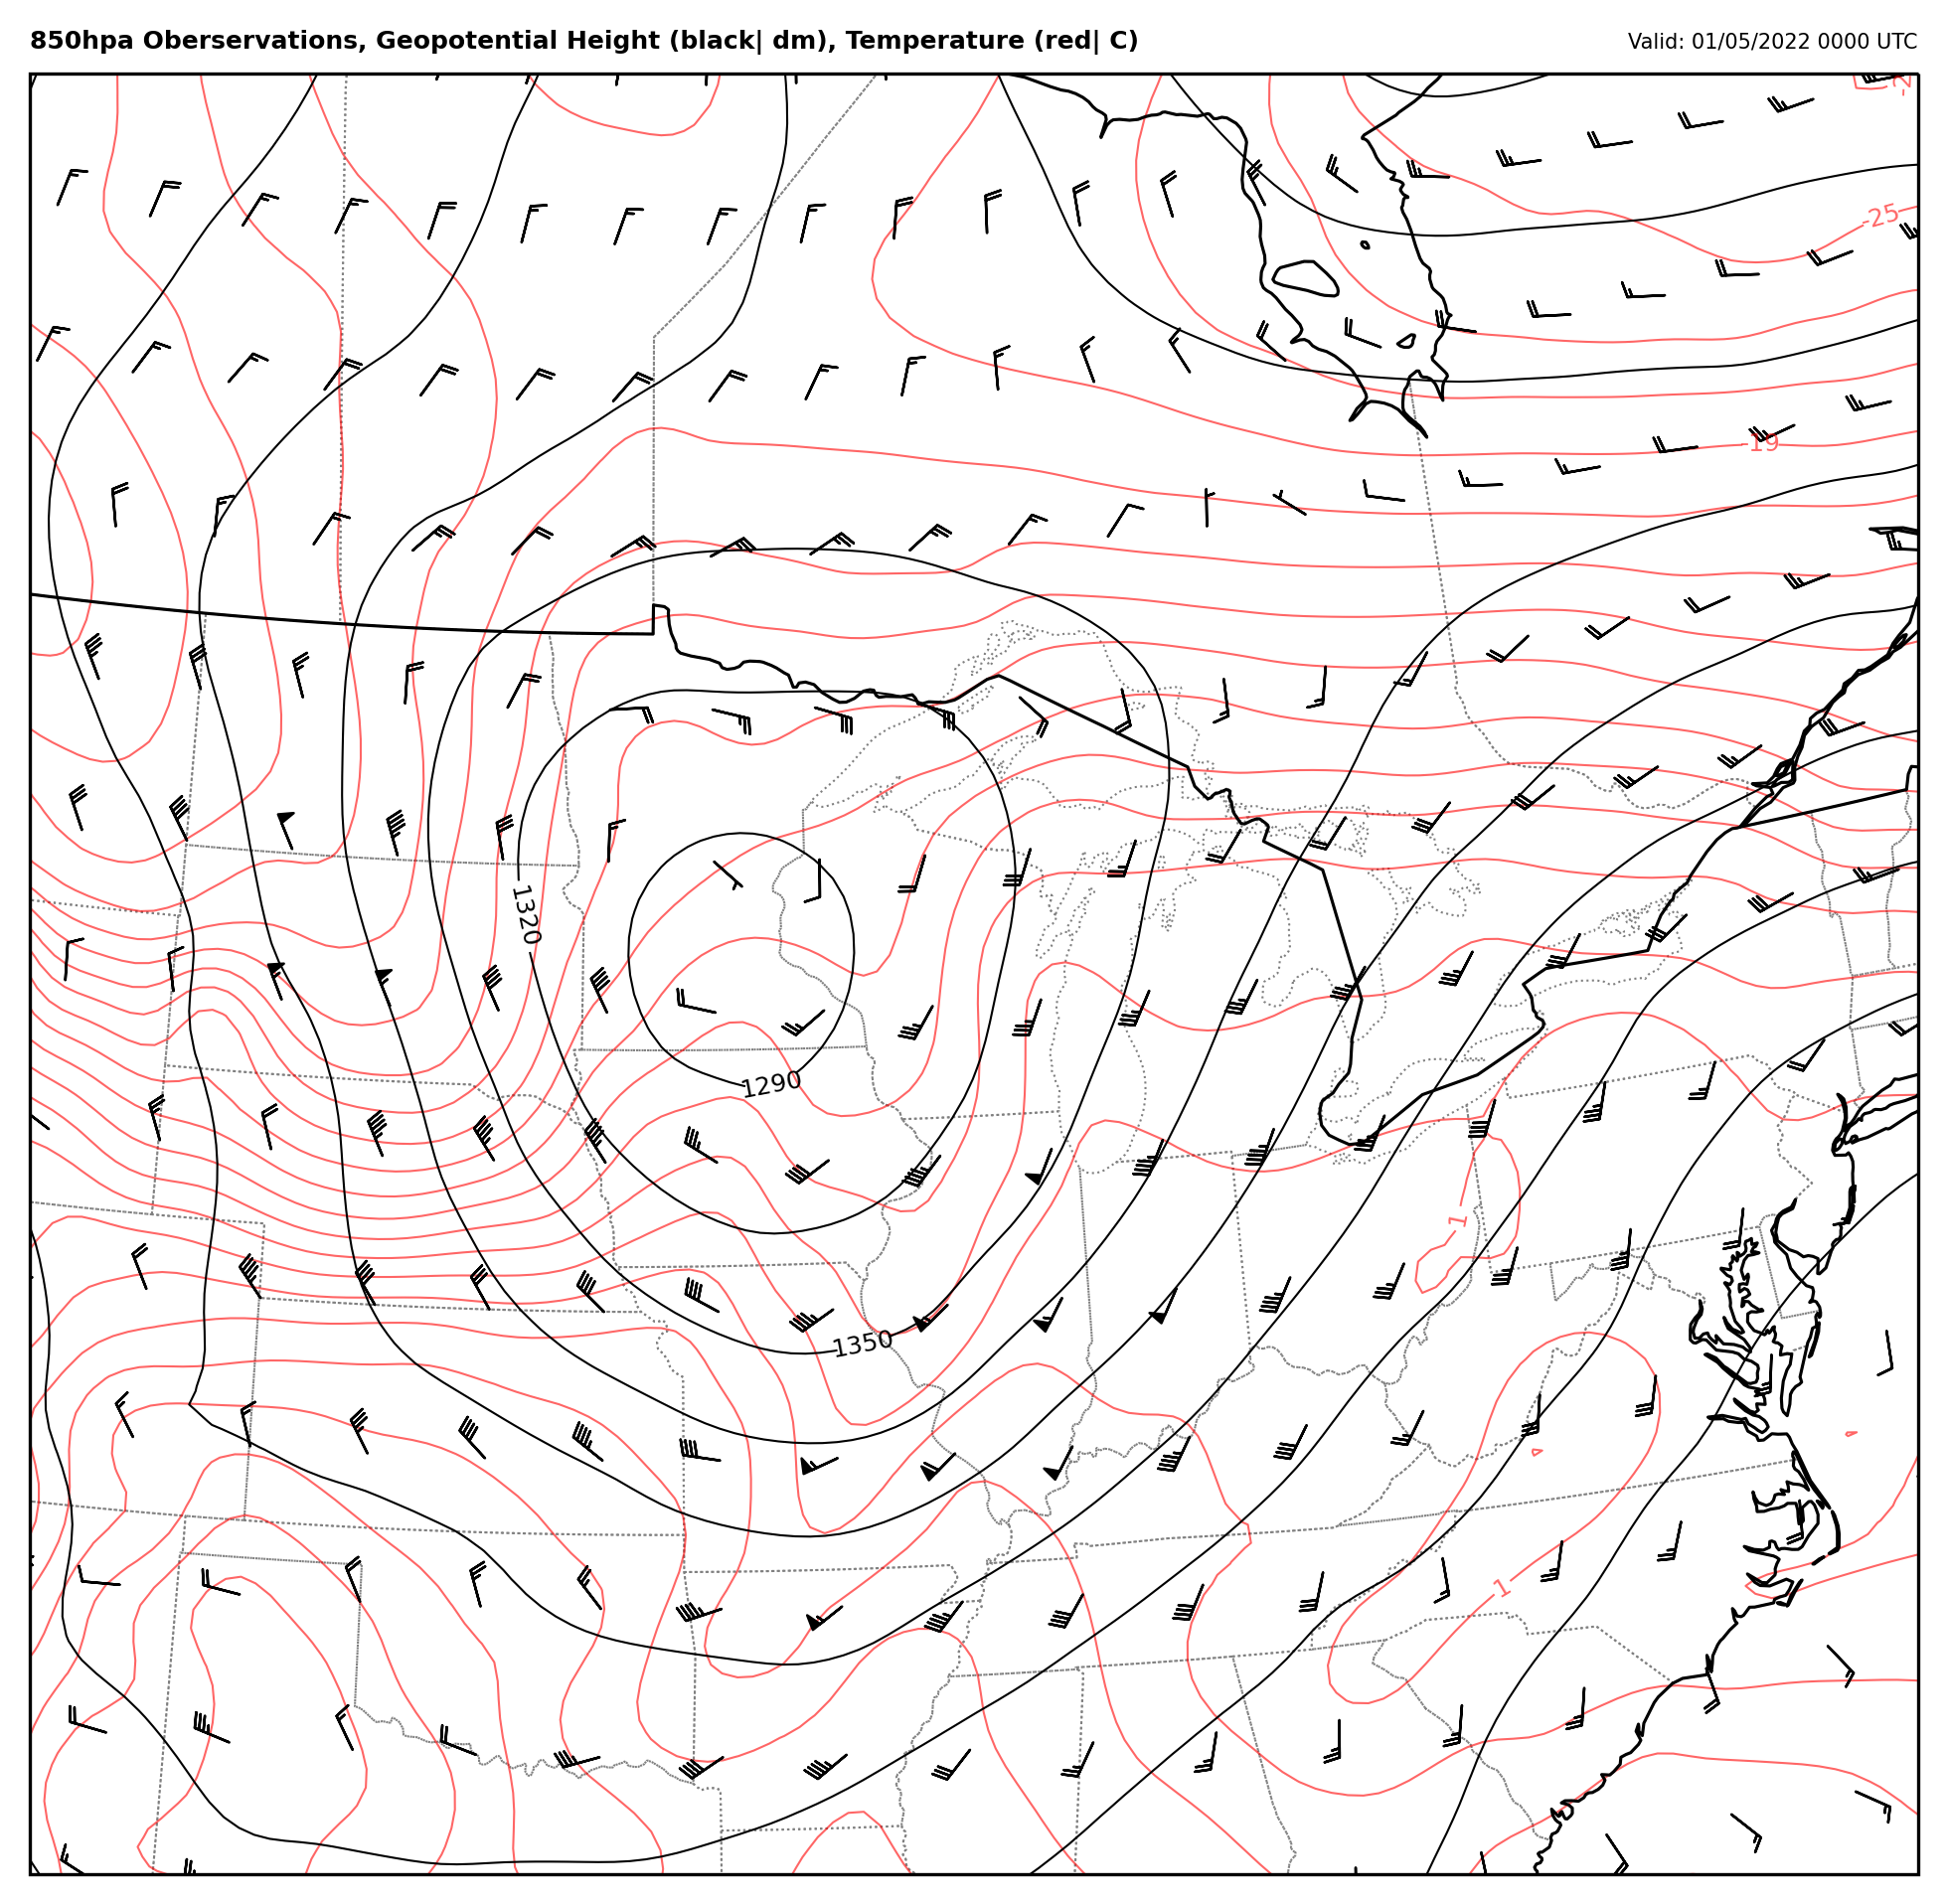

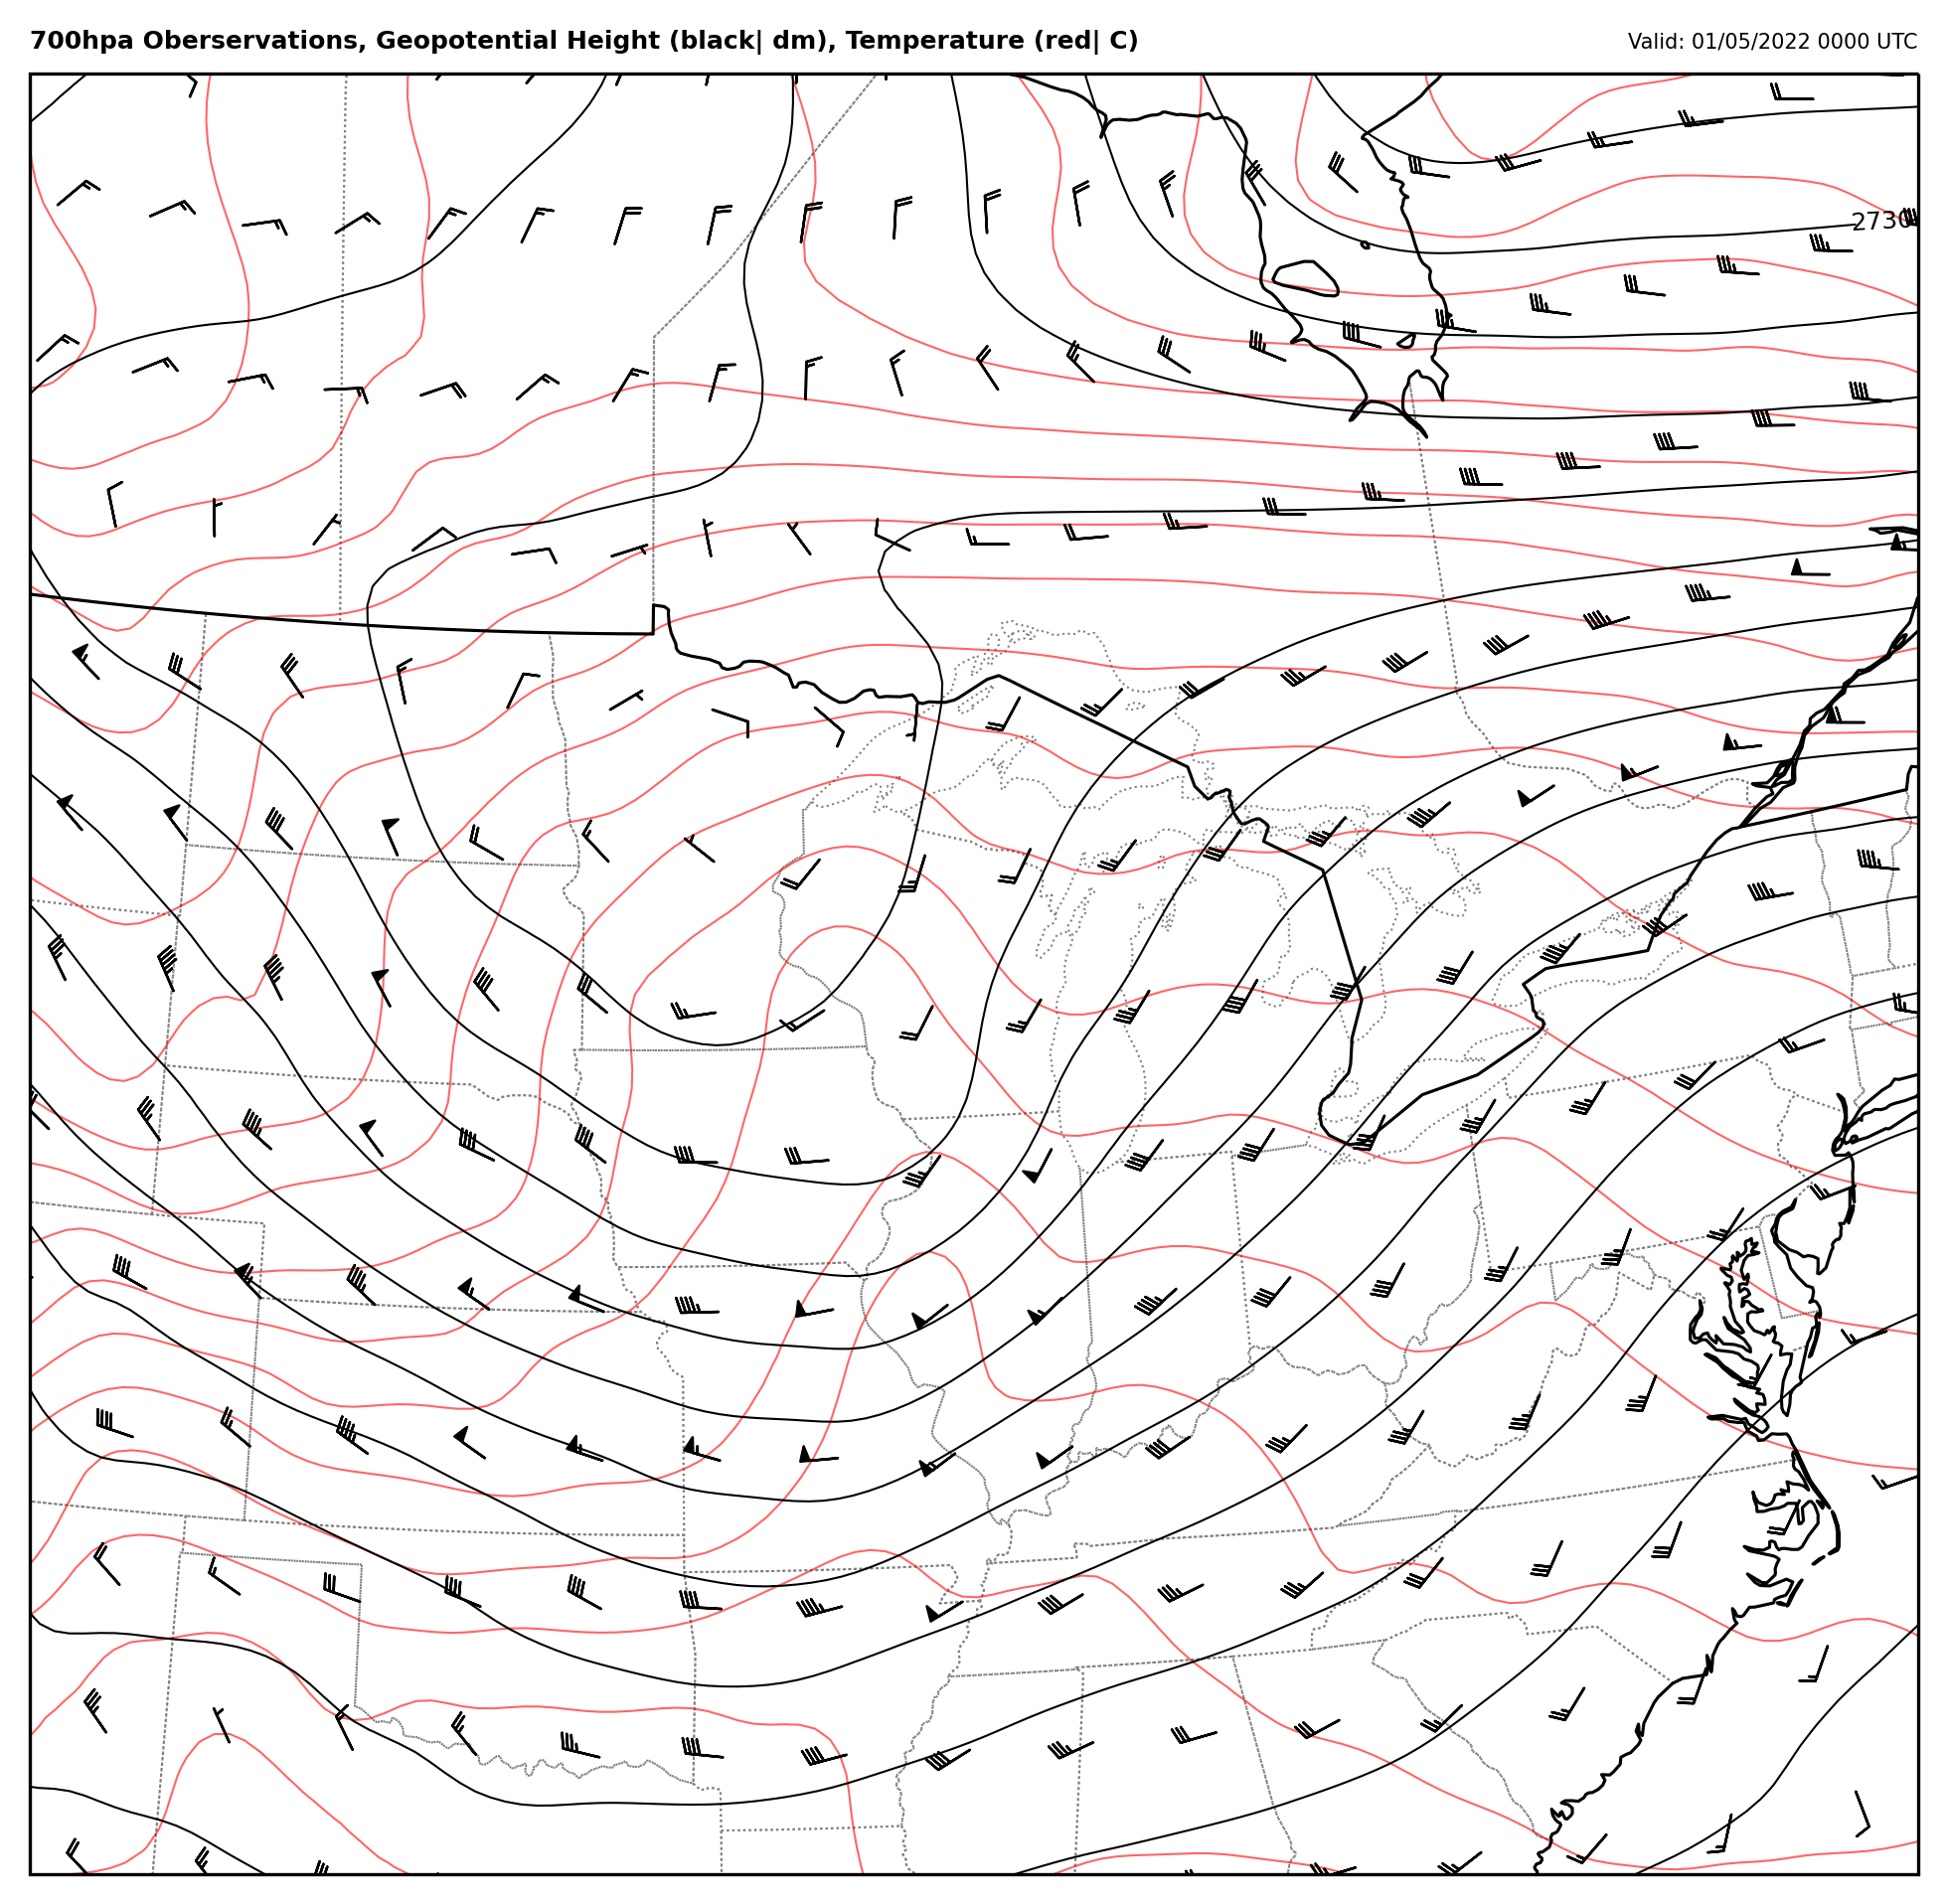

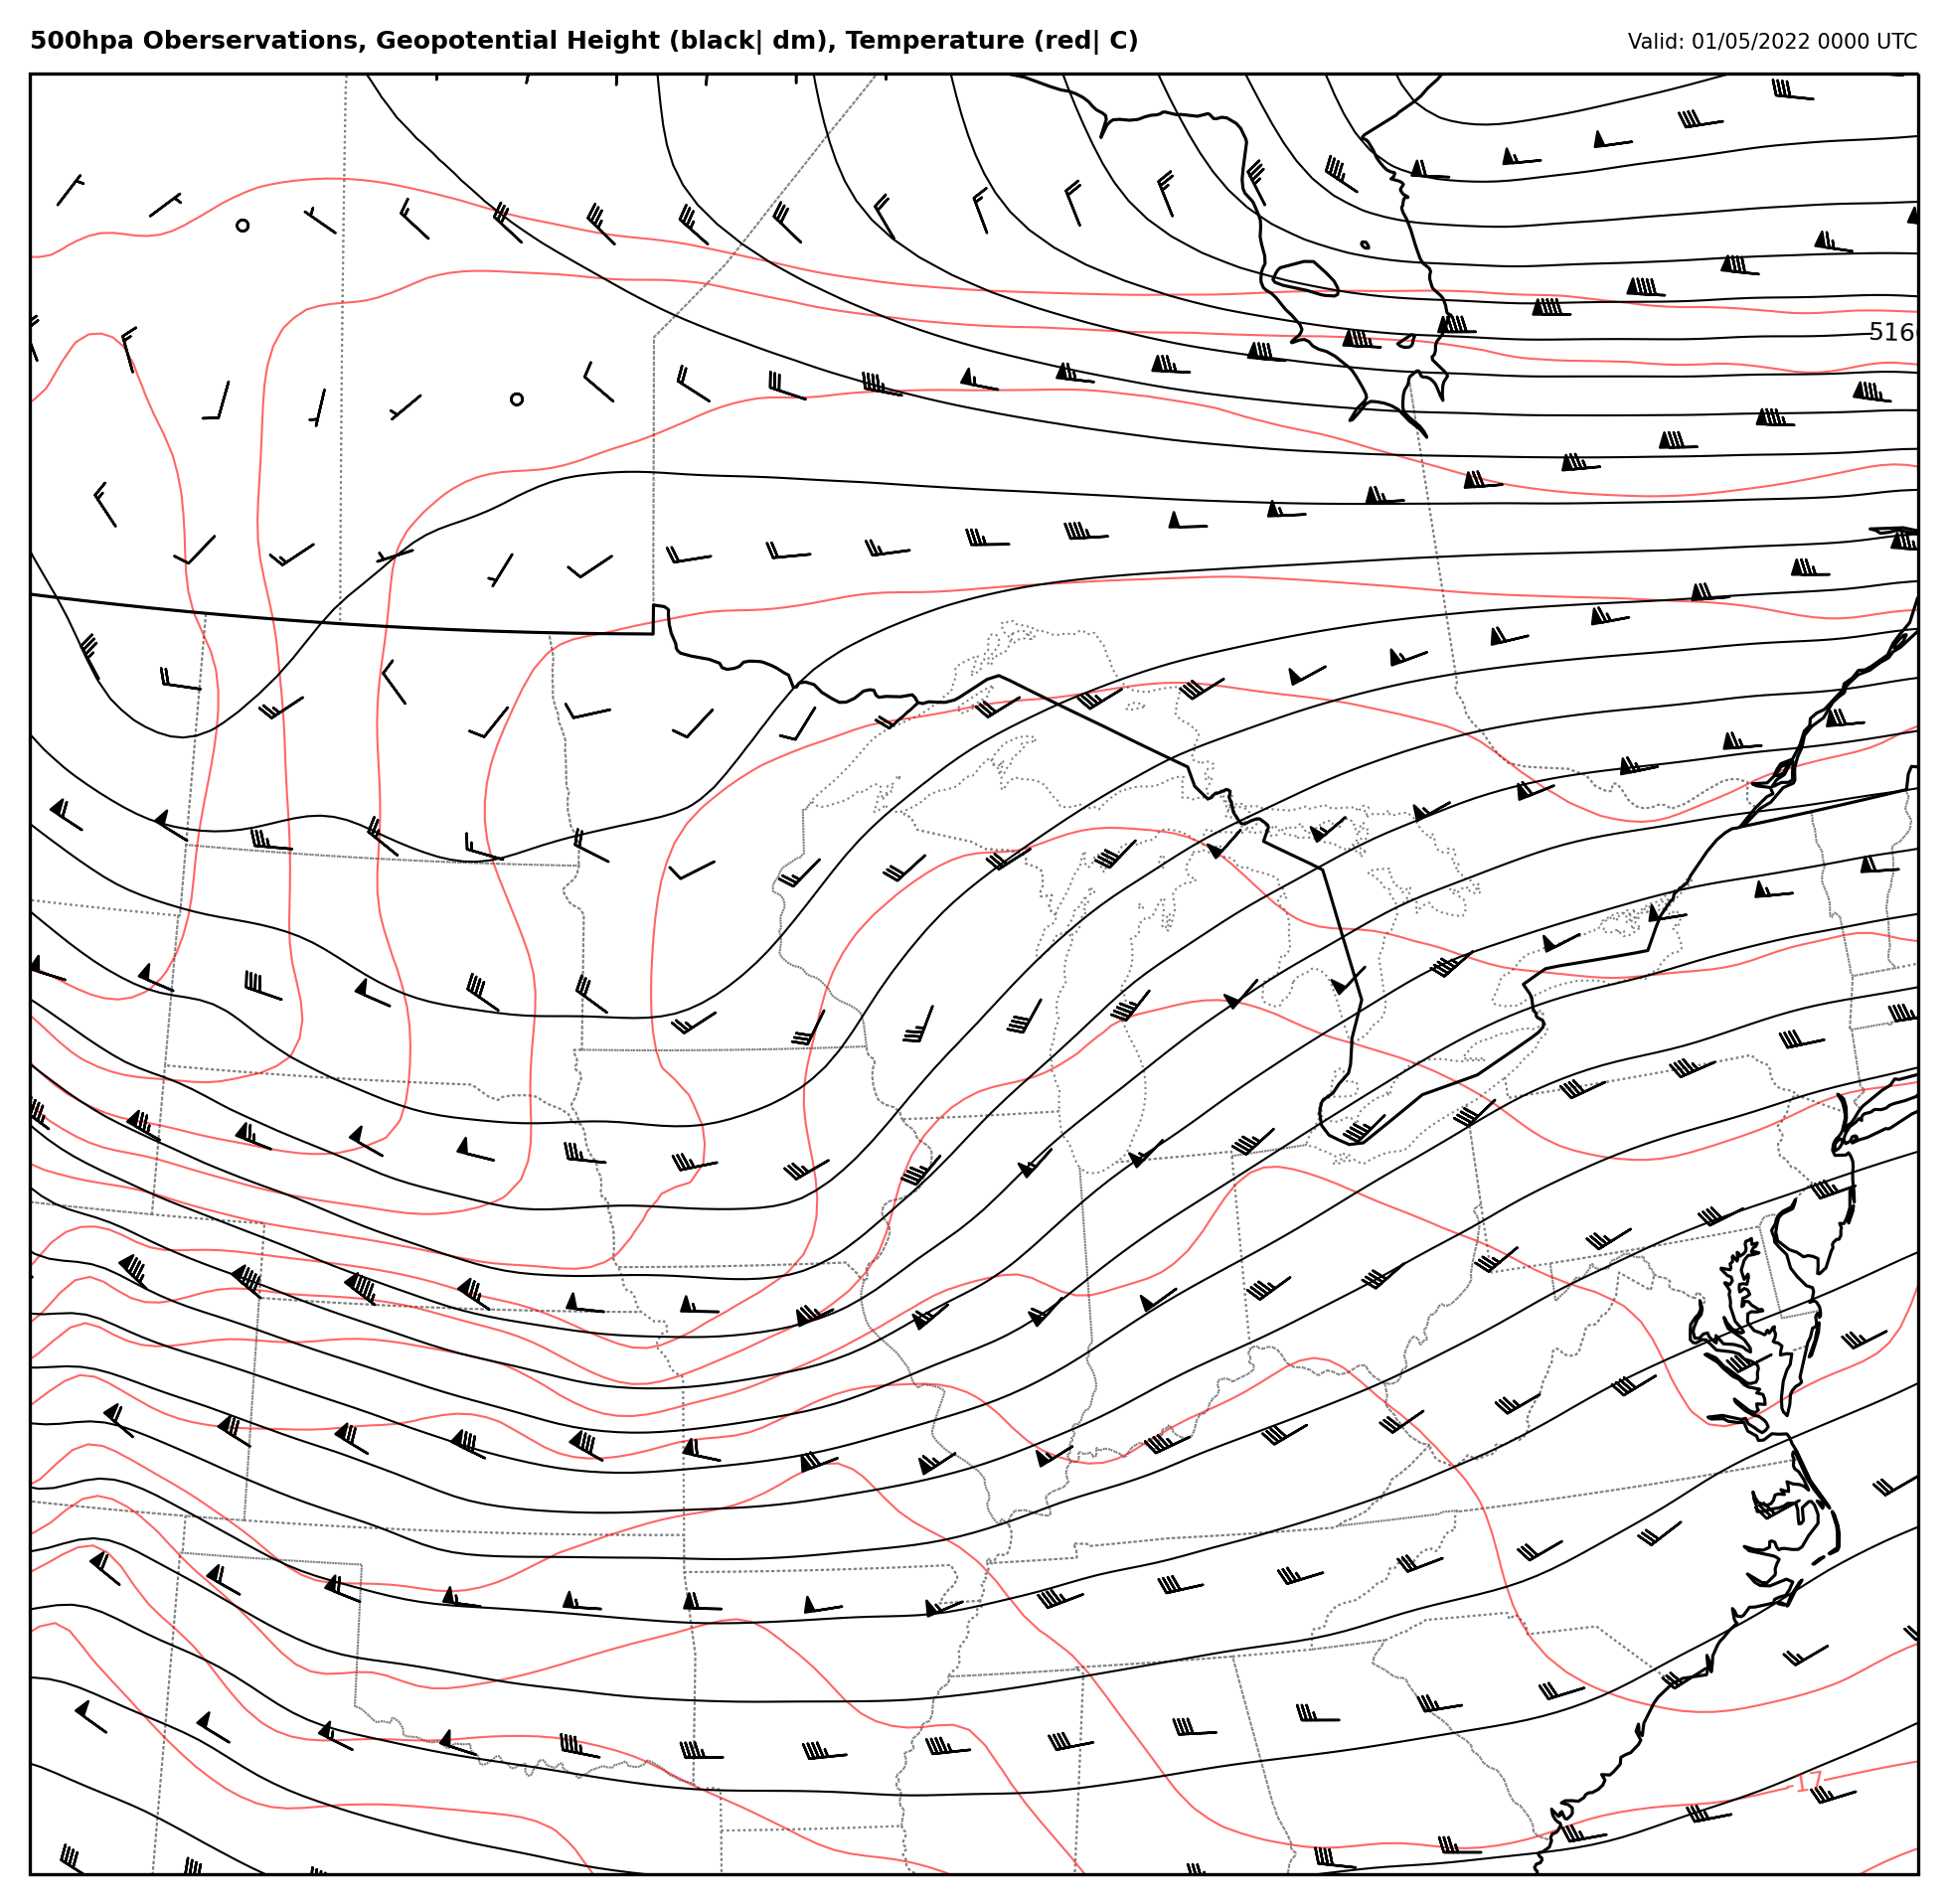

In [5]:
level=850
gfs_temp_upper_air_plot(model_data, level, time)

level=700
gfs_temp_upper_air_plot(model_data, level, time)

level=500
gfs_temp_upper_air_plot(model_data, level, time)


<br /><br />
6. We need one extra timestep of data to complete the lab.  Re-run your data processing script for January 5th, 2022 at 1200 UTC, then re-run your plotting script only at 500 hPa.

Can't create file '/data/AtmSci360/Lab_8/010522_12_gfs.grib2.923a8.idx'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 522, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/opt/tljh/user/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 488, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: '/data/AtmSci360/Lab_8/010522_12_gfs.grib2.923a8.idx'
Can't read index file '/data/AtmSci360/Lab_8/010522_12_gfs.grib2.923a8.idx'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 532, in from_indexpath_or_filestream
    index_mtime = os.path.getmtime(indexpath)
  File "/opt/tljh/user/lib/python3.7/genericpath.py", line 55, in getmti

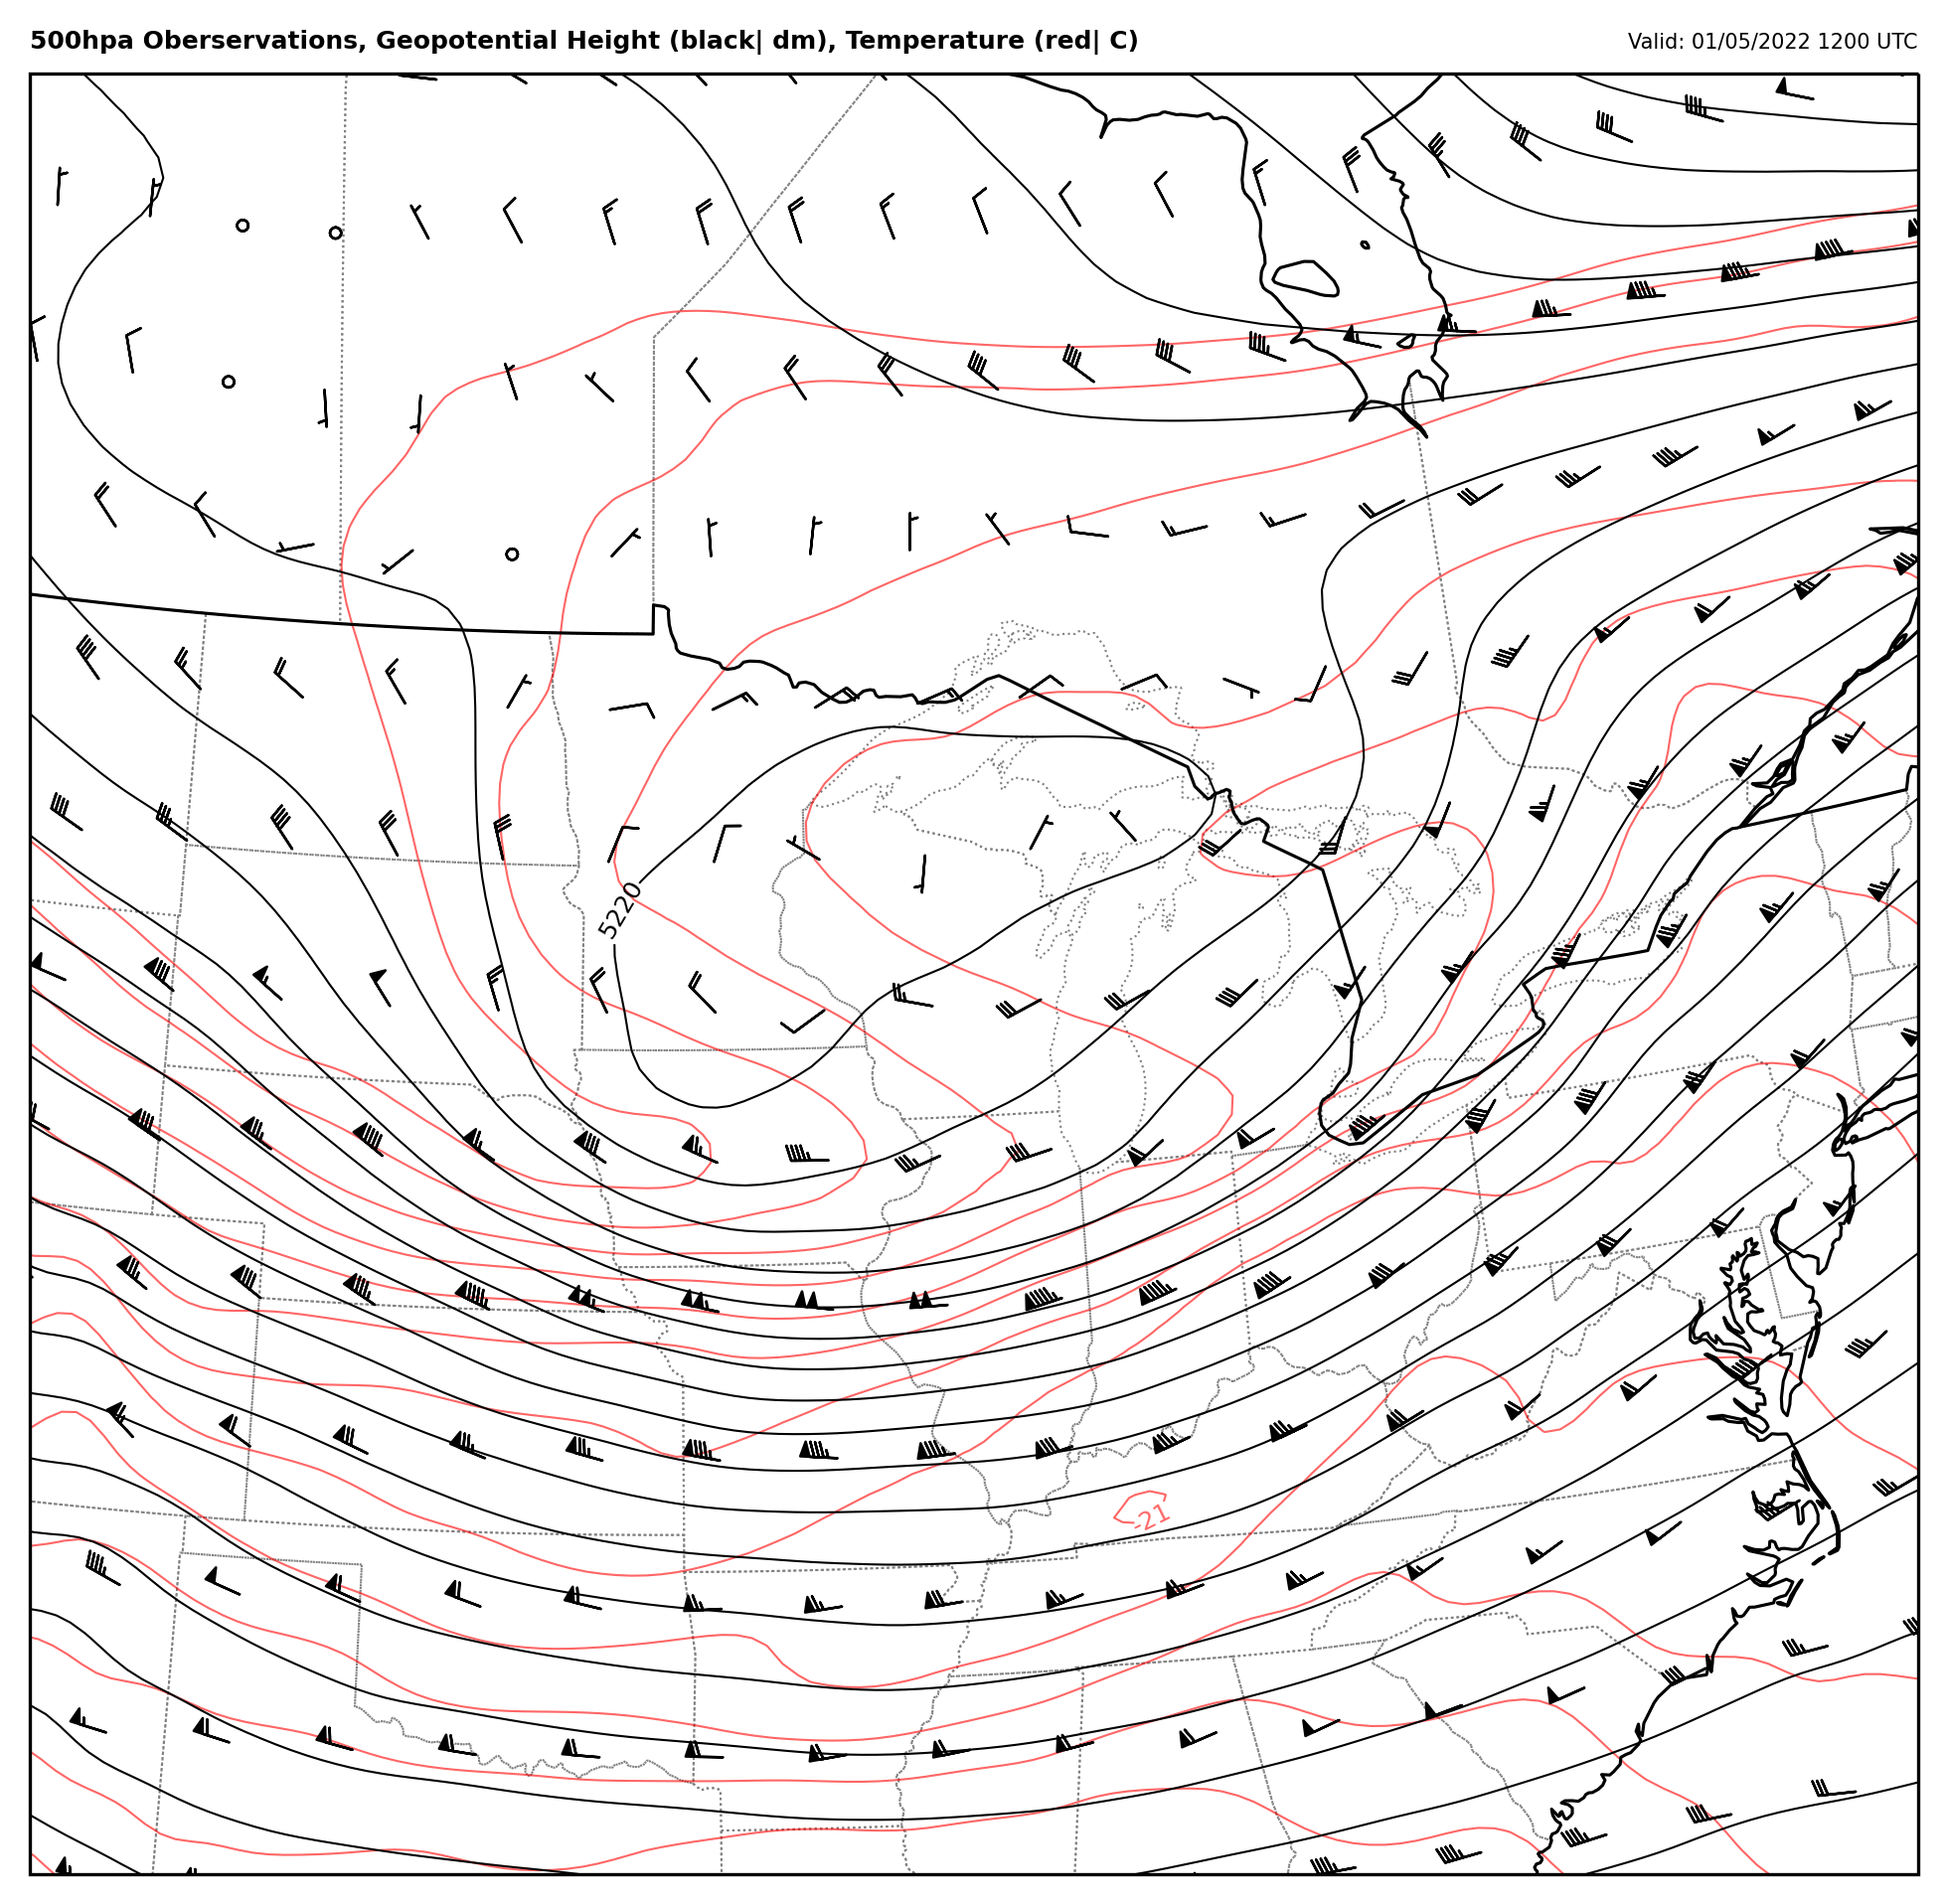

Can't create file '/data/AtmSci360/Lab_8/010522_12_gfs.grib2.923a8.idx'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 522, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/opt/tljh/user/lib/python3.7/contextlib.py", line 112, in __enter__
    return next(self.gen)
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 488, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
PermissionError: [Errno 13] Permission denied: '/data/AtmSci360/Lab_8/010522_12_gfs.grib2.923a8.idx'
Can't read index file '/data/AtmSci360/Lab_8/010522_12_gfs.grib2.923a8.idx'
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.7/site-packages/cfgrib/messages.py", line 532, in from_indexpath_or_filestream
    index_mtime = os.path.getmtime(indexpath)
  File "/opt/tljh/user/lib/python3.7/genericpath.py", line 55, in getmti

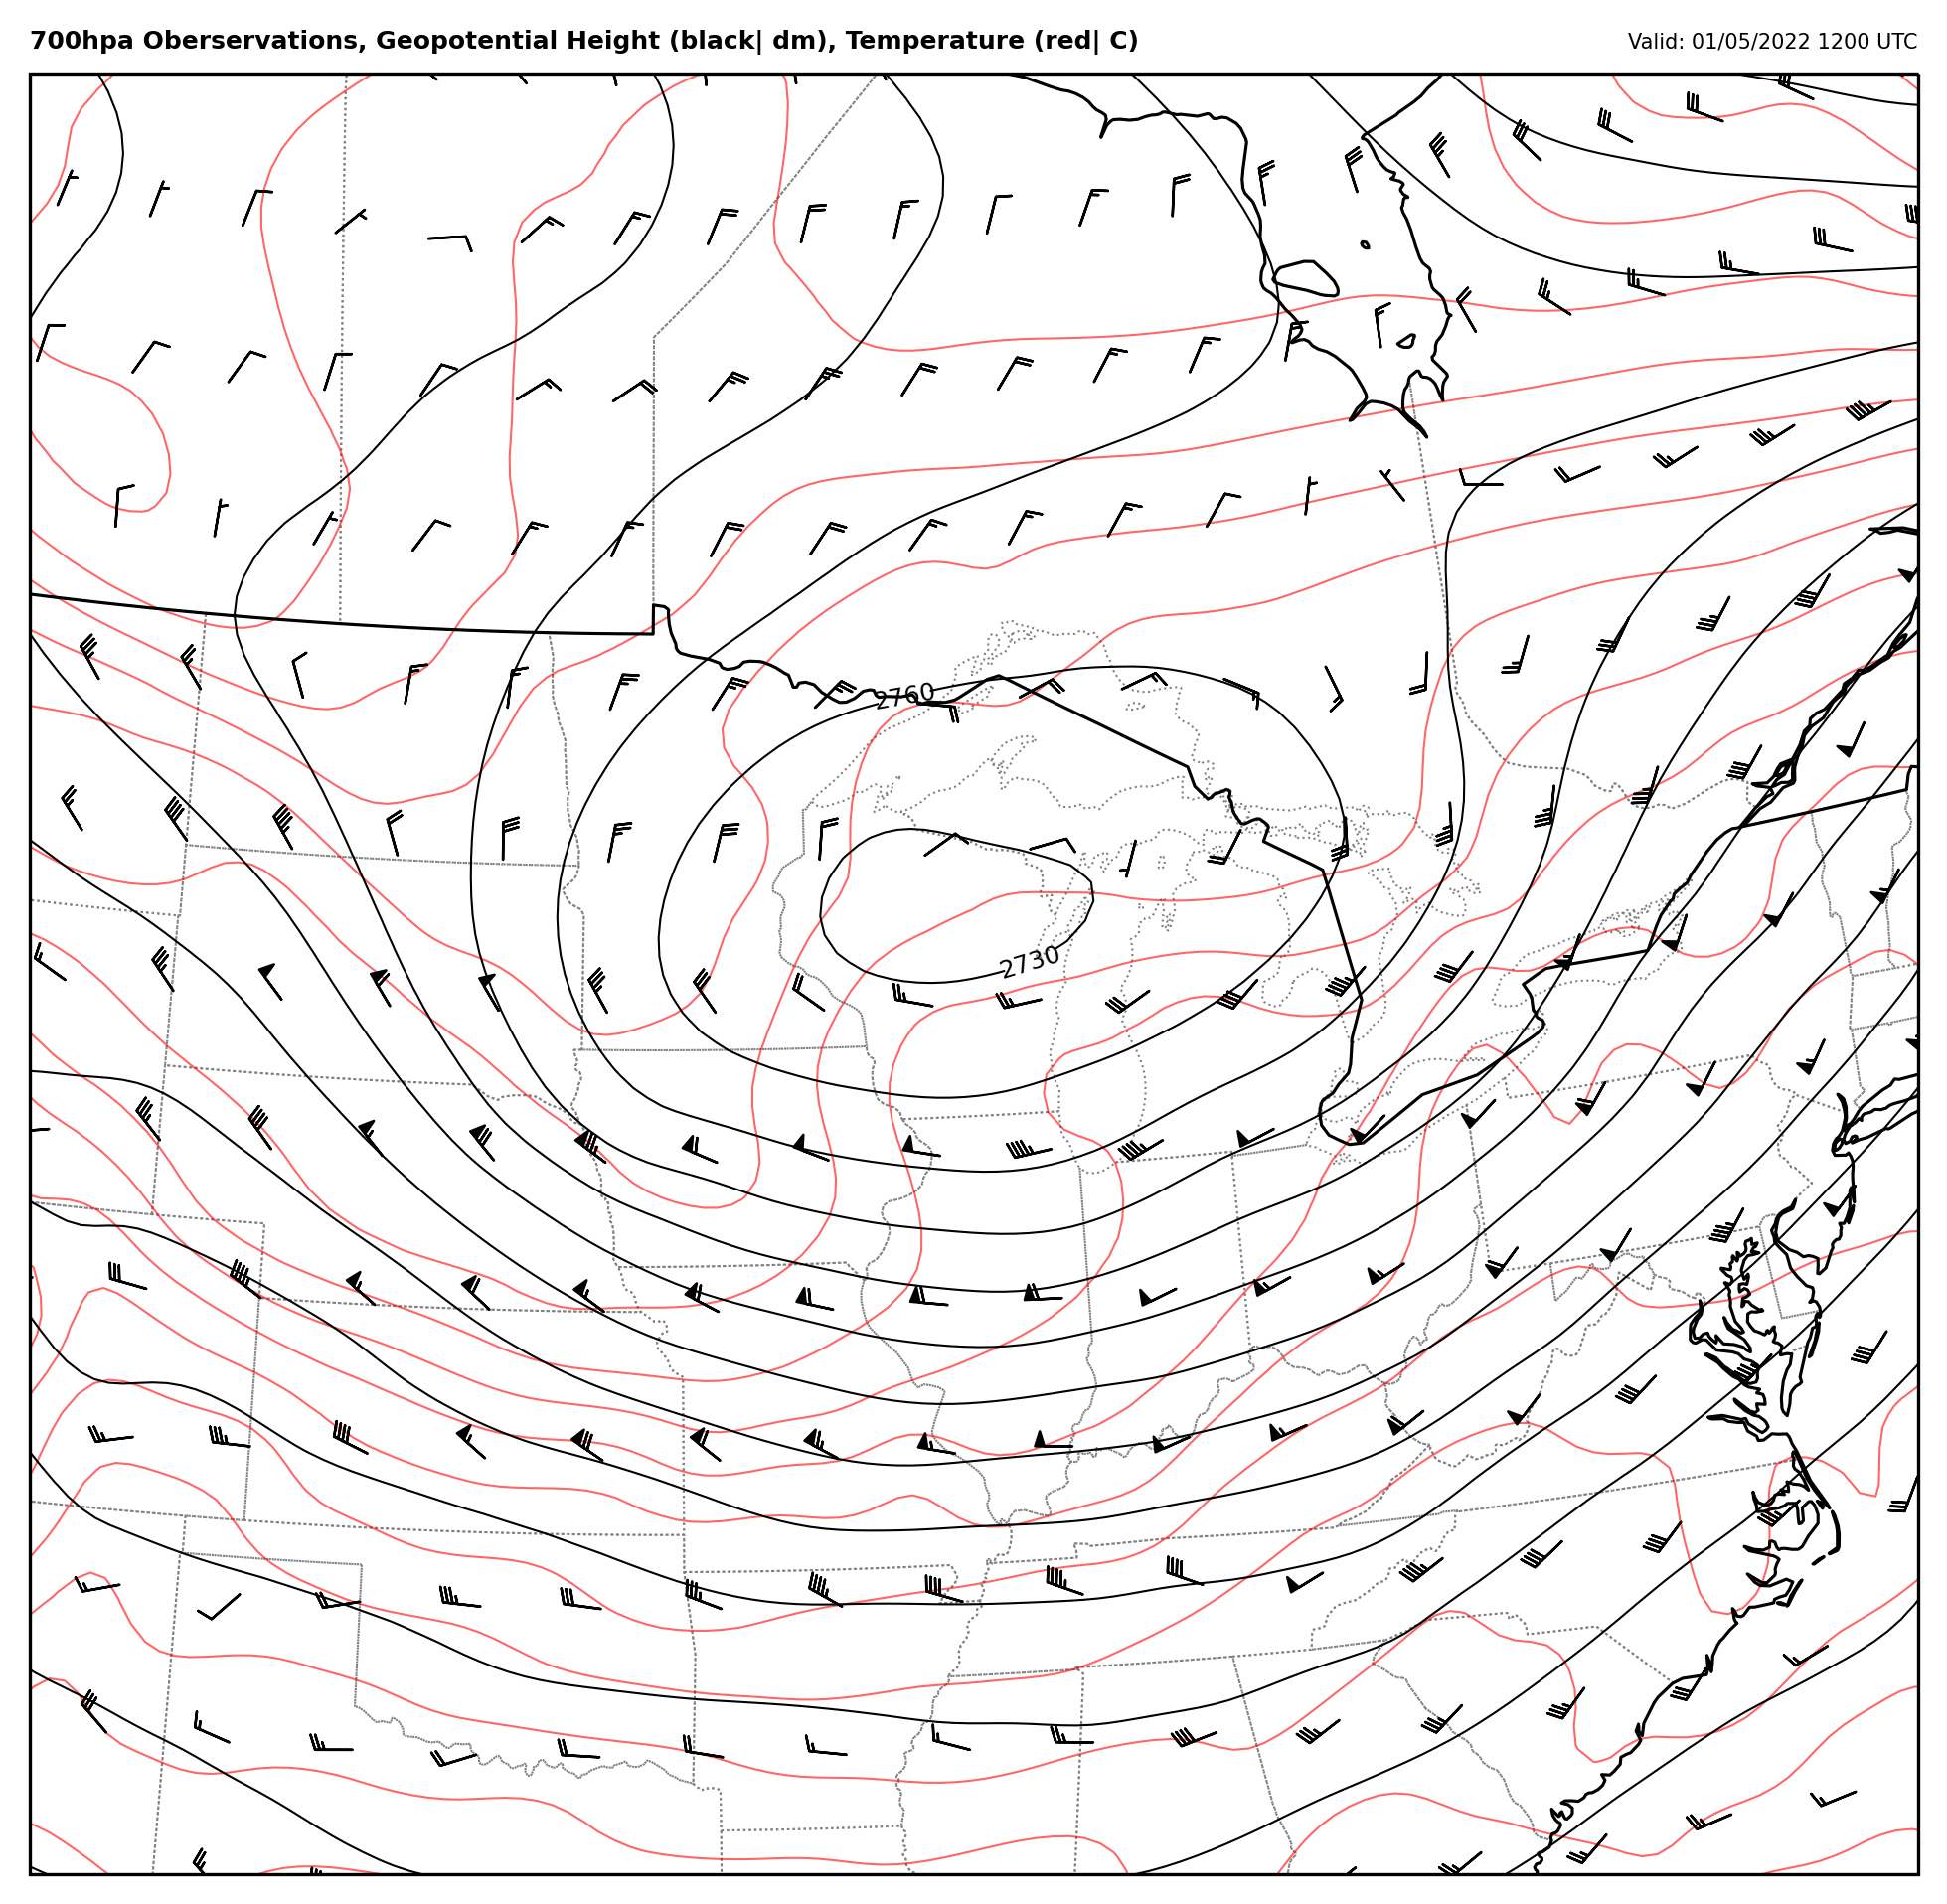

In [6]:
time=datetime(2022,1,5,12)
model_data=process_upper_air_data(time)
level=500
gfs_temp_upper_air_plot(model_data, level, time)

#Question 10 asks for 700hpa map at 12UTC as well
time=datetime(2022,1,5,12)
model_data=process_upper_air_data(time)
level=700
gfs_temp_upper_air_plot(model_data, level, time)

### You have now completed Part II of the Python portion of the lab.  Be sure to submit the fully rendered Jupyter Notebook on GitHub when you are finished.